# Homework 1

## FINM 37400 - 2025

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

### Data

This homework uses the data file, `treasury_quotes_2024-10-31`.

The problems below analyze the nominal, (rather than the TIPS,) Treasury issues. Accordingly, you should filter out all rows with `type` `TIPS Note` or `TIPS bond`.

***

# 1. Discount Rates

Use the data in the `selected quotes` tab.

Note:
* The selected treasuries are at nearly six-month intervals. 
* If you prefer, approximate that they mature at perfect 6-month intervals. 

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import sys
from sklearn.linear_model import LinearRegression
import warnings
from scipy.optimize import fsolve

notebook_dir = "homework"
if notebook_dir in os.getcwd():
    os.chdir("..")
print(os.getcwd())

import cmds.treasury_cmds as tc


c:\Users\Andik\OneDrive\Desktop\Chicago\fixed_income\finm-fixedincome-2025


In [21]:
# Load data
selected_quotes_data = pd.read_excel("data/treasury_quotes_2024-10-31.xlsx",
                                        sheet_name="selected quotes",
                                        parse_dates=True)

display(selected_quotes_data.head())
display(selected_quotes_data.info())
print(selected_quotes_data["type"].unique())

,KYTREASNO,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm
0,208042,note,2024-10-31,2023-04-30,2025-04-30,0.495551,0,3.875,99.712500,99.722203,99.717351,0,99.717351,0.044933
1,208129,note,2024-10-31,2023-10-31,2025-10-31,0.999316,0,5.000,100.641406,100.660819,100.651113,0,100.651113,0.043311
2,208213,note,2024-10-31,2024-04-30,2026-04-30,1.494867,0,4.875,100.929688,100.960938,100.945312,0,100.945312,0.042327
3,208302,note,2024-10-31,2024-10-31,2026-10-31,1.998631,0,4.125,99.933594,99.941406,99.937500,0,99.937500,0.041611
4,207875,note,2024-10-31,2022-04-30,2027-04-30,2.494182,0,2.750,96.750000,96.781250,96.765625,0,96.765625,0.041346


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   KYTREASNO         14 non-null     int64         
 1   type              14 non-null     object        
 2   quote date        14 non-null     datetime64[ns]
 3   issue date        14 non-null     datetime64[ns]
 4   maturity date     14 non-null     datetime64[ns]
 5   ttm               14 non-null     float64       
 6   accrual fraction  14 non-null     int64         
 7   cpn rate          14 non-null     float64       
 8   bid               14 non-null     float64       
 9   ask               14 non-null     float64       
 10  price             14 non-null     float64       
 11  accrued int       14 non-null     int64         
 12  dirty price       14 non-null     float64       
 13  ytm               14 non-null     float64       
dtypes: datetime64[ns](3), float6

None

['note']


### 1.1.

Create the cashflow matrix, $\textbf{C}$, where each rows is a Treasury issue, each column is a date, and each entry is the cash paid on a (normalized) face value of \$100.

In [22]:

quote_date_column = "quote date"
maturity_date_column = "maturity date"
coupon_rate = "cpn rate"
index_col = "KYTREASNO"

def filter_treasury_cashflows(CF, filter_maturity_dates=False, filter_benchmark_dates=False, filter_CF_strict=True):

    mask_benchmark_dts = []
    
    # Filter by using only benchmark treasury dates
    for col in CF.columns:
        if filter_benchmark_dates:
            if col.month in [2,5,8,11] and col.day == 15:
                mask_benchmark_dts.append(col)
        else:
            mask_benchmark_dts.append(col)
    
    if filter_maturity_dates:
        mask_maturity_dts = CF.columns[(CF>=100).any()]
    else:
        mask_maturity_dts = CF.columns
    
    mask = [i for i in mask_benchmark_dts if i in mask_maturity_dts]

    CF_filtered = CF[mask]
          
    if filter_CF_strict:
        # drop issues that had CF on excluded dates
        mask_bnds = CF_filtered.sum(axis=1) == CF.sum(axis=1)
        CF_filtered = CF_filtered[mask_bnds]

    else:
        # drop issues that have no CF on included dates
        mask_bnds = CF_filtered.sum(axis=1) > 0
        CF_filtered = CF_filtered[mask_bnds]
        
        
    # update to drop dates with no CF
    CF_filtered = CF_filtered.loc[:,(CF_filtered>0).any()]
    
    return CF_filtered


def cash_flow_matrix(data:pd.DataFrame,
                     quote_date_column:str,
                     maturity_date_column:str,
                     coupon_rate_column:str,
                     index_col:str = None,
                     face_value:float = 100) -> pd.DataFrame:
    """
    Create cash flow matrix for each quote date
    """
    quote_data = data.copy()
    quote_data.rename(columns={coupon_rate_column: "cpn_rate",
                               maturity_date_column:"maturity_date",
                               quote_date_column:"quote_date"}, inplace=True)
    # first set up cash flow dataframe
    if index_col is not None:
        cf_df = pd.DataFrame(data = 0, index = quote_data[index_col],
                            columns = quote_data.loc[:,'maturity_date'].unique())
        quote_data.set_index(index_col, inplace=True)
    else:
        cf_df = pd.DataFrame(data = 0, index = quote_data.index,
                         columns = quote_data.loc[:,'maturity_date'].unique())

    # function to apply to each row
    for row in quote_data.itertuples():
        # Remaining time to maturity
        time_to_maturity = (row.maturity_date - row.quote_date).days
        periods_remaining = np.ceil(time_to_maturity / 180).astype(int)
        date_range = pd.date_range(end=row.maturity_date, 
                                   periods=periods_remaining, 
                                   freq=pd.DateOffset(months=6))
        # filter date ranges
        date_range = date_range[date_range > row.quote_date]
        # coupon payment
        coupon_payment = row.cpn_rate/ 2
        # set cash flow
        cf_df.loc[row.Index, date_range] = coupon_payment
        # set face value
        cf_df.loc[row.Index, row.maturity_date] += face_value        
        
    cf_df = cf_df.fillna(0)
    cf_df = cf_df.reindex(sorted(cf_df.columns), axis=1)
    cf_df = cf_df.resample('M', axis=1).sum()
    
    
    # Just drop columns with no securities matruing on that date
    # cf_df.drop(columns=cf_df.columns[~(cf_df>=100).any()],inplace=True)
    cf_df.drop(columns=cf_df.columns[(cf_df==0).all()],inplace=True)

    # cf_df = filter_treasury_cashflows(cf_df,
    #                                   filter_maturity_dates=True)
    return cf_df



In [23]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    cashflow_data = cash_flow_matrix(selected_quotes_data,
                                    quote_date_column,
                                    maturity_date_column,
                                    coupon_rate,
                                    index_col)
    display(cashflow_data)

    validation_data = selected_quotes_data.rename(columns={
        'quote date': 'CALDT',
        'maturity date': 'TMATDT',
        'cpn rate': 'TCOUPRT'
    })
    validation_data = tc.calc_cashflows(validation_data,filter_maturity_dates=False)
    validation_data.columns = pd.to_datetime(validation_data.columns)
    validation_data = validation_data.resample('M', axis=1).sum()
    validation_data = validation_data.drop(columns = validation_data.columns[(validation_data == 0).all()])
    validation = np.all(cashflow_data.values == validation_data.values)
    if validation:
        print("Cash flow matrix is correct")
    else:
        print("Cash flow matrix is incorrect")
                                 

,2025-04-30,2025-10-31,2026-04-30,2026-10-31,2027-04-30,2027-10-31,2028-04-30,2028-10-31,2029-04-30,2029-10-31,2030-04-30,2030-10-31,2031-04-30,2031-10-31
KYTREASNO,,,,,,,,,,,,,,
208042,101.9375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208129,2.5000,102.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208213,2.4375,2.4375,102.4375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208302,2.0625,2.0625,2.0625,102.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207875,1.3750,1.3750,1.3750,1.3750,101.3750,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207960,2.0625,2.0625,2.0625,2.0625,2.0625,102.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208044,1.7500,1.7500,1.7500,1.7500,1.7500,1.7500,101.7500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208132,2.4375,2.4375,2.4375,2.4375,2.4375,2.4375,2.4375,102.4375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208216,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,102.3125,0.0000,0.0000,0.0000,0.0000,0.0000


Cash flow matrix is correct


### 1.2.

Estimate the spot discount factors that rationalize the market prices of the treasuries. Do this via solving the linear system

$$\textbf{p} = {\textbf{C}}\, \textbf{z}$$

In [24]:
price_data = selected_quotes_data["price"]
discount_factors = np.linalg.inv(cashflow_data) @ price_data
display(discount_factors)
discount_factor_data = pd.DataFrame(data = discount_factors,
             index = cashflow_data.columns,
             columns=["spot discount factor"])


array([0.97822049, 0.95810304, 0.93935838, 0.92106705, 0.90303423,
       0.88485588, 0.86632685, 0.84811994, 0.83111031, 0.81446174,
       0.79632959, 0.77902394, 0.76195606, 0.74636869])

### 1.3.

Plot the time-to-maturity on the horizontal axis. On the vertical axis, plot the...
* discount factors

Make another plot, this time with the vertical axis displaying the
* semiannually compounded discount rates
* continuously compounded discount rates

In [25]:
print(discount_factors)

[0.97822049 0.95810304 0.93935838 0.92106705 0.90303423 0.88485588
 0.86632685 0.84811994 0.83111031 0.81446174 0.79632959 0.77902394
 0.76195606 0.74636869]


Text(0.5, 1.0, 'Spot Discount Factors against maturity dates')

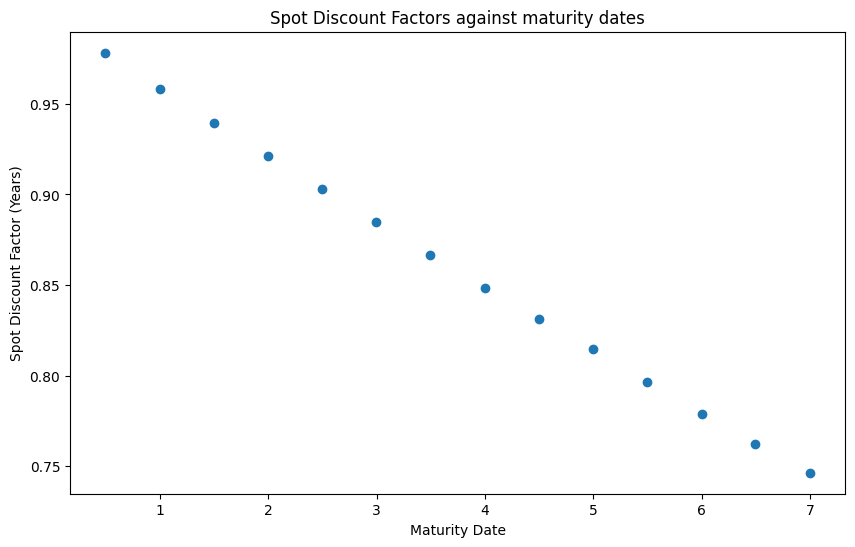

In [26]:
current_date = pd.Timestamp("2024-10-31")
discount_factor_data["time_to_maturity"] = (discount_factor_data.index - current_date).days / 365.25

plt.figure(figsize=(10,6))
plt.scatter(x=discount_factor_data["time_to_maturity"].values, y=discount_factor_data["spot discount factor"].values)
plt.xlabel("Maturity Date")
plt.ylabel("Spot Discount Factor (Years)")
plt.title("Spot Discount Factors against maturity dates")
                       

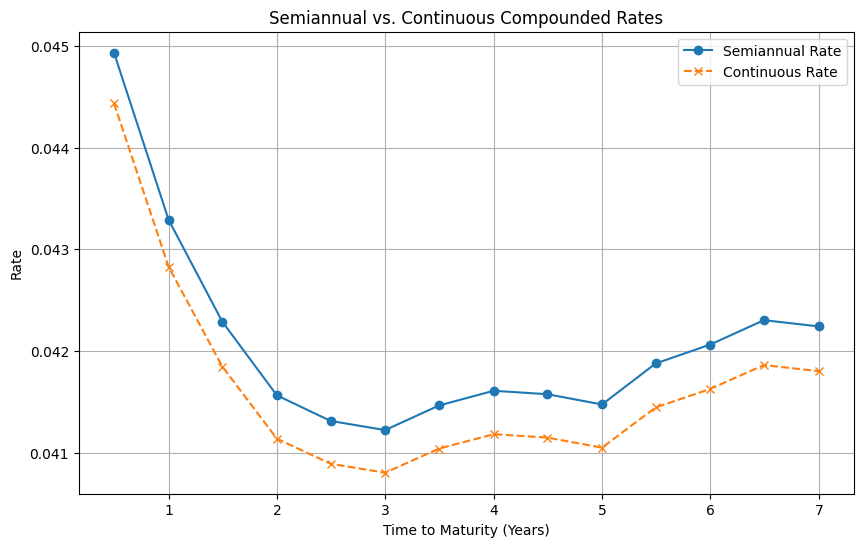

            spot discount factor  time_to_maturity  semiannual rate  \
2025-04-30              0.978220          0.495551         0.044933   
2025-10-31              0.958103          0.999316         0.043291   
2026-04-30              0.939358          1.494867         0.042290   
2026-10-31              0.921067          1.998631         0.041565   
2027-04-30              0.903034          2.494182         0.041314   
2027-10-31              0.884856          2.997947         0.041224   
2028-04-30              0.866327          3.496235         0.041466   
2028-10-31              0.848120          4.000000         0.041610   
2029-04-30              0.831110          4.495551         0.041576   
2029-10-31              0.814462          4.999316         0.041475   
2030-04-30              0.796330          5.494867         0.041879   
2030-10-31              0.779024          5.998631         0.042065   
2031-04-30              0.761956          6.494182         0.042304   
2031-1

In [27]:
# Semi-annual compounded discount rate

# let discount factor be y
# n is number of compounding periods per year
# t is the time in years

# Define a function to calculate the semiannual compounded rate
def semiannual_rate(spot_df, t, n=2):
    # Function to solve for rate using the equation y = 1 / (1 + rate/n)^(n*t)
    def equation(rate):
        return 1 / (1 + rate / n) ** (n * t) - spot_df

    # Solve using fsolve
    initial_guess = 0.05  # Initial guess for the rate (5%)
    rate_solution = fsolve(equation, initial_guess)[0]
    return rate_solution

# Continuous Compounding
def continuous_rate(spot_df, t):
    # Solve for r using the formula y = e^(-r*t)
    return -np.log(spot_df) / t

discount_factor_data["semiannual rate"] = discount_factor_data.apply(
    lambda row: semiannual_rate(row["spot discount factor"], row["time_to_maturity"]), axis=1
)

discount_factor_data["continuous rate"] = discount_factor_data.apply(
    lambda row: continuous_rate(row["spot discount factor"], row["time_to_maturity"]), axis=1
)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(discount_factor_data["time_to_maturity"], discount_factor_data["semiannual rate"], label="Semiannual Rate", marker='o', linestyle='-')
plt.plot(discount_factor_data["time_to_maturity"], discount_factor_data["continuous rate"], label="Continuous Rate", marker='x', linestyle='--')
plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Rate")
plt.title("Semiannual vs. Continuous Compounded Rates")
plt.legend()
plt.grid(True)
plt.show()

# Print the resulting DataFrame
print(discount_factor_data)



### 1.4.

Suppose that all discount rates and all coupon rates go up by 0.5\%. 

Calculate the new price of each of the treasury securities, using present value pricing.

In [28]:
selected_quotes_data_new = selected_quotes_data.copy()
selected_quotes_data_new["cpn rate"] = selected_quotes_data_new["cpn rate"] + 0.005
cashflow_data_new = cash_flow_matrix(selected_quotes_data_new,
                                    quote_date_column,
                                    maturity_date_column,
                                    coupon_rate,
                                    index_col)
price_data = cashflow_data_new @ discount_factors
display(price_data.to_frame(name="price adjusted"))

C:\Users\Andik\AppData\Local\Temp\ipykernel_8404\920561517.py:79: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.94' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cf_df.loc[row.Index, date_range] = coupon_payment
C:\Users\Andik\AppData\Local\Temp\ipykernel_8404\920561517.py:79: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.44' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cf_df.loc[row.Index, date_range] = coupon_payment
C:\Users\Andik\AppData\Local\Temp\ipykernel_8404\920561517.py:79: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.3775' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cf_df.loc[row.Index, date_ra

,price adjusted
KYTREASNO,
208042,99.719797
208129,100.655953
208213,100.952502
208302,99.946992
207875,96.777374
207960,100.017868
208044,97.938002
208132,102.621763
208216,101.932435


***

# 2. Estimating the Discount Curve with Real Data

Use the data in the `quotes` tab.

### 2.1. Map Cashflows

Construct the cashflow matrix.

Given the unfiltered data set, you will need to make a few modeling choices to do this...
* eliminate any treasury that does not report YTM or that reports a negative YTM.
* assume notes and bonds pay coupons every six months, going backward from the date of maturity.

Make other reasonable modeling assumptions as needed.

Report:
* head and tail rows of the dataframe, $\textbf{C}$, for instance, using `display()`.

* which date has the most cashflow across all issues?

* which date has the most issues paying a cashflow?

In [29]:
quotes_data = pd.read_excel("data/treasury_quotes_2024-10-31.xlsx",
                            sheet_name="quotes",
                            parse_dates=True)
display(quotes_data.head())
# Remove Tips related treasury securities
quotes_data = quotes_data[~quotes_data["type"].isin(["TIPS bond", "TIPS note"])]
#Eliminate treasuries that does not report YTM or report negative YTM
quotes_data = quotes_data[(quotes_data["ytm"] > 0) & (quotes_data["ytm"].notnull())]
print(quotes_data["type"].unique())
display(quotes_data.info())

,KYTREASNO,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm
0,208246,bill,2024-10-31,2024-07-09,2024-11-05,0.013689,0.972621,0.0,99.947806,99.947917,99.947861,0.000000,99.947861,0.038463
1,208222,bill,2024-10-31,2024-05-09,2024-11-07,0.019165,0.961670,0.0,99.922356,99.922522,99.922439,0.000000,99.922439,0.040899
2,208247,bill,2024-10-31,2024-07-16,2024-11-12,0.032854,0.934292,0.0,99.857458,99.857764,99.857611,0.000000,99.857611,0.043844
3,208223,bill,2024-10-31,2024-05-16,2024-11-14,0.038330,0.923340,0.0,99.832571,99.832932,99.832751,0.000000,99.832751,0.044151
4,204083,bond,2024-10-31,1994-05-15,2024-11-15,0.041068,0.918478,7.5,100.114004,100.114405,100.114204,3.444293,103.558498,0.045497


['bill' 'bond' 'note']
<class 'pandas.core.frame.DataFrame'>
Index: 395 entries, 0 to 447
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   KYTREASNO         395 non-null    int64         
 1   type              395 non-null    object        
 2   quote date        395 non-null    datetime64[ns]
 3   issue date        395 non-null    datetime64[ns]
 4   maturity date     395 non-null    datetime64[ns]
 5   ttm               395 non-null    float64       
 6   accrual fraction  395 non-null    float64       
 7   cpn rate          395 non-null    float64       
 8   bid               395 non-null    float64       
 9   ask               395 non-null    float64       
 10  price             395 non-null    float64       
 11  accrued int       395 non-null    float64       
 12  dirty price       395 non-null    float64       
 13  ytm               395 non-null    float64       
dtypes: datet

None

In [30]:
# construct cashflow matrix
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    cashflow_data = cash_flow_matrix(quotes_data,
                                    quote_date_column,
                                    maturity_date_column,
                                    coupon_rate,
                                    index_col)
    display(cashflow_data)
    validation_data = quotes_data.rename(columns={
        'quote date': 'CALDT',
        'maturity date': 'TMATDT',
        'cpn rate': 'TCOUPRT'
    })
    validation_data = tc.calc_cashflows(validation_data,filter_maturity_dates=False)
    validation_data.columns = pd.to_datetime(validation_data.columns)
    validation_data = validation_data.resample('M', axis=1).sum()
    # drop columns where every value is zero
    validation_data = validation_data.drop(columns = validation_data.columns[(validation_data == 0).all()])
    validation = np.all(cashflow_data.values == validation_data.values)
    if validation:
        print("Cash flow matrix is correct")
    else:
        print("Cash flow matrix is incorrect")
        


,2024-11-30,2024-12-31,2025-01-31,2025-02-28,2025-03-31,2025-04-30,2025-05-31,2025-06-30,2025-07-31,2025-08-31,...,2052-05-31,2052-08-31,2052-11-30,2053-02-28,2053-05-31,2053-08-31,2053-11-30,2054-02-28,2054-05-31,2054-08-31
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208246,100.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000
208222,100.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000
208247,100.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000
208223,100.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000
204083,103.7500,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208107,0.0000,0.0,0.0,2.0625,0.0,0.0,0.0000,0.0,0.0,2.0625,...,0.0000,2.0625,0.0000,2.0625,0.0000,102.0625,0.0000,0.000,0.0000,0.000
208149,2.3750,0.0,0.0,0.0000,0.0,0.0,2.3750,0.0,0.0,0.0000,...,2.3750,0.0000,2.3750,0.0000,2.3750,0.0000,102.3750,0.000,0.0000,0.000
208178,0.0000,0.0,0.0,2.1250,0.0,0.0,0.0000,0.0,0.0,2.1250,...,0.0000,2.1250,0.0000,2.1250,0.0000,2.1250,0.0000,102.125,0.0000,0.000


Cash flow matrix is correct


### 2.2. OLS

Estimate the discount factors using OLS.

Starting with the cashflow matrix, $C$, create an additional filter to get a subset where every date has at least one maturity, (possibly multiple,) and every issue has its maturity in the cashflow matrix. Call this set of cashflows, $\hat{C}$.

**Report 5 head and tail rows of $\hat{C}$.**

$$\textbf{p} = \hat{\textbf{C}}\,\textbf{z}_{\text{ols}}+\epsilon$$

Plot the time-to-maturity vs discount rates, semiannually compounded.

In [31]:
# For OLS restrict to at least one treasury maturing on that date
cashflow_data_ols = cashflow_data[cashflow_data.columns[(cashflow_data>=100).any()]]
validation_data_ols= validation_data[validation_data.columns[(validation_data>=100).any()]]
validation = np.all(cashflow_data_ols.values == validation_data_ols.values)
if validation:
    print("Cash flow matrix is correct")
else:
    print("Cash flow matrix is incorrect")
display(cashflow_data_ols)

Cash flow matrix is correct


,2024-11-30,2024-12-31,2025-01-31,2025-02-28,2025-03-31,2025-04-30,2025-05-31,2025-06-30,2025-07-31,2025-08-31,...,2052-05-31,2052-08-31,2052-11-30,2053-02-28,2053-05-31,2053-08-31,2053-11-30,2054-02-28,2054-05-31,2054-08-31
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208246,100.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000
208222,100.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000
208247,100.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000
208223,100.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000
204083,103.7500,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208107,0.0000,0.0,0.0,2.0625,0.0,0.0,0.0000,0.0,0.0,2.0625,...,0.0000,2.0625,0.0000,2.0625,0.0000,102.0625,0.0000,0.000,0.0000,0.000
208149,2.3750,0.0,0.0,0.0000,0.0,0.0,2.3750,0.0,0.0,0.0000,...,2.3750,0.0000,2.3750,0.0000,2.3750,0.0000,102.3750,0.000,0.0000,0.000
208178,0.0000,0.0,0.0,2.1250,0.0,0.0,0.0000,0.0,0.0,2.1250,...,0.0000,2.1250,0.0000,2.1250,0.0000,2.1250,0.0000,102.125,0.0000,0.000


,OLS spot discount factor,time_to_maturity
2024-11-30,0.991618,0.082136
2024-12-31,0.991355,0.167009
2025-01-31,0.988255,0.251882
2025-02-28,0.983813,0.328542
2025-03-31,0.982278,0.413415
...,...,...
2053-08-31,0.312216,28.832307
2053-11-30,0.328910,29.081451
2054-02-28,0.308188,29.327858
2054-05-31,0.320794,29.579740


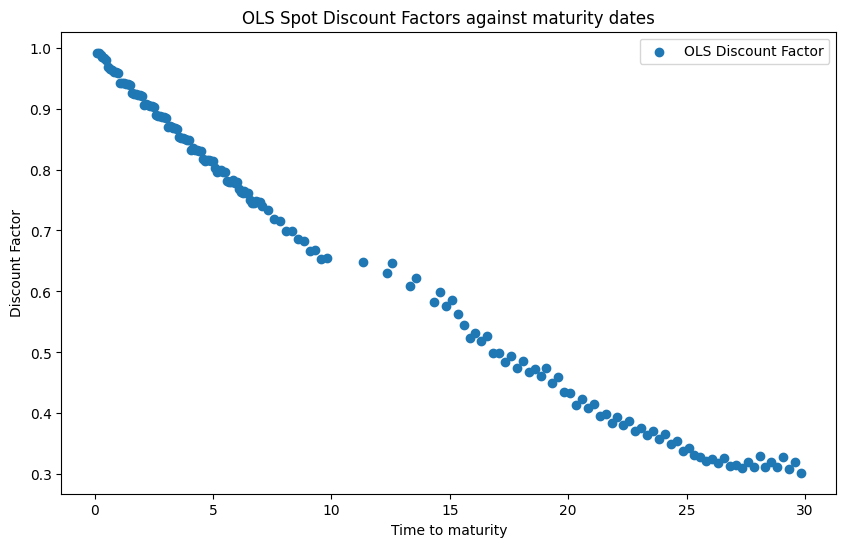

In [32]:
# OLS regression
model = LinearRegression(fit_intercept=False)
y = quotes_data[quotes_data["KYTREASNO"].isin(cashflow_data_ols.index)]["price"].values
X = cashflow_data_ols.values

model.fit(X, y)
z_ols = model.coef_

ols_results = pd.DataFrame(data = z_ols,
                            index = cashflow_data_ols.columns,
                            columns=["OLS spot discount factor"])
current_date = pd.Timestamp("2024-10-31")
ols_results["time_to_maturity"] = (ols_results.index - current_date).days / 365.25
display(ols_results)
plt.figure(figsize=(10,6))
plt.scatter(x=ols_results['time_to_maturity'], y=ols_results["OLS spot discount factor"].values, label="OLS Discount Factor")
plt.xlabel("Time to maturity")
plt.ylabel("Discount Factor")
plt.title("OLS Spot Discount Factors against maturity dates")
plt.legend()
plt.show()

### 2.3. EXTRA (not graded)

Re-do `2.2.`, but this time use Weighted Least Squares. Find a weighting scheme that puts more weight on more recently issued treasures and less weight on less recently issued treasures. 

Does your answer change much?



Weight statistics:
Min weight: 9.190331770976932e-05
Max weight: 0.16666666666666666


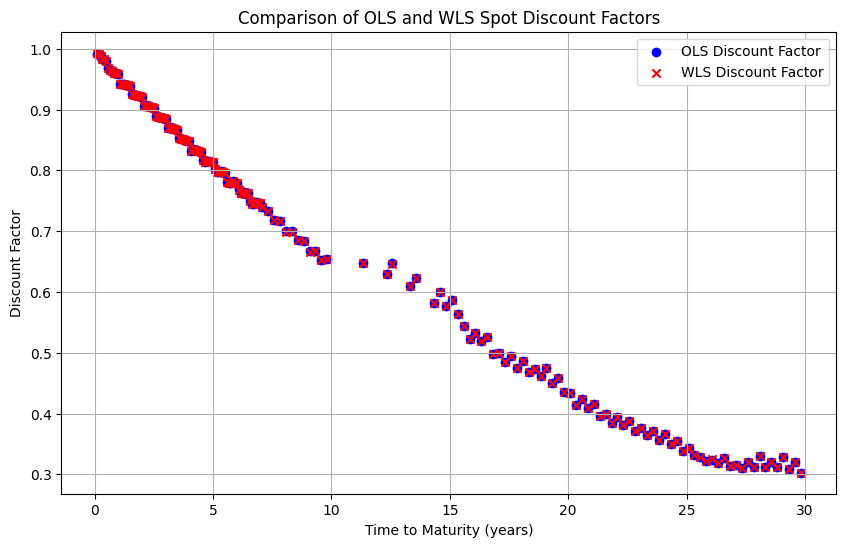

,WLS spot discount factor,time_to_maturity
2024-11-30,0.993492,0.082136
2024-12-31,0.992115,0.167009
2025-01-31,0.988639,0.251882
2025-02-28,0.983967,0.328542
2025-03-31,0.982437,0.413415
...,...,...
2053-08-31,0.312259,28.832307
2053-11-30,0.328962,29.081451
2054-02-28,0.308231,29.327858
2054-05-31,0.320843,29.579740


In [33]:
def compute_weights(quote_date, maturity_date):
    """
    Compute weights based on time to maturity.
    Bonds closer to maturity have higher weights.
    
    Args:
        quote_date (pd.Timestamp): Date of quote
        maturity_date (pd.Series): Series of maturity dates
    
    Returns:
        pd.Series: Weights for each bond based on time to maturity
    """
    days_to_maturity = (maturity_date - quote_date).dt.days
    weights = 1 / (days_to_maturity + 1)  # Add 1 to avoid division by zero
    
    # Add diagnostics
    print("\nWeight statistics:")
    print(f"Min weight: {weights.min()}")
    print(f"Max weight: {weights.max()}")
    return weights

# Parameters
QUOTE_DATE = pd.Timestamp("2024-10-31")

# Data preparation
X = cashflow_data_ols
y = quotes_data[quotes_data["KYTREASNO"].isin(cashflow_data_ols.index)]["price"].values

# Compute and apply weights using maturity dates
weights = compute_weights(QUOTE_DATE, quotes_data["maturity date"])  
sqrt_weights = np.sqrt(weights.values)

weighted_X = X * sqrt_weights[:, np.newaxis]
weighted_y = y * sqrt_weights

# Fit weighted least squares model
model_wls = LinearRegression(fit_intercept=False)
model_wls.fit(weighted_X, weighted_y)

# Store results
wls_results = pd.DataFrame(
    data=model_wls.coef_,
    index=cashflow_data_ols.columns,
    columns=["WLS spot discount factor"]
)
wls_results["time_to_maturity"] = (wls_results.index - QUOTE_DATE).days / 365.25

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(
    ols_results["time_to_maturity"], 
    ols_results["OLS spot discount factor"],
    label="OLS Discount Factor", 
    color="blue", 
    marker="o"
)
plt.scatter(
    wls_results["time_to_maturity"], 
    wls_results["WLS spot discount factor"],
    label="WLS Discount Factor", 
    color="red", 
    marker="x"
)

plt.xlabel("Time to Maturity (years)")
plt.ylabel("Discount Factor")
plt.title("Comparison of OLS and WLS Spot Discount Factors")
plt.legend()
plt.grid(True)
plt.show()

# Display results
display(wls_results)

### 2.4. Curve-Fitting

Continue with the model of cashflows (having filtered out some treasuries).

Estimate the discount curve via the Nelson-Siegel model.
* Fit via minimizing the sum of squared errors of the modeled prices against the quoted prices.
* Consider using `minimize` from `scipy.optimize`.

When done,
* Report the estimated NS parameters.
* Plot the semiannually-compounded discount rates along with those estimated with OLS from above.

In [45]:
nelson_seigel_cashflow_data = cashflow_data_ols.copy()
nelson_seigel_parameters = tc.estimate_rate_curve(tc.nelson_siegel,
                       CF = nelson_seigel_cashflow_data,
                       t_current= pd.Timestamp("2024-10-31"),
                       prices = quotes_data[quotes_data["KYTREASNO"].isin(nelson_seigel_cashflow_data.index)]["price"].values,
                       x0 = np.ones(4)/10)
display(nelson_seigel_parameters)

array([0.04064126, 0.01138827, 0.00803886, 0.40459023])

Index([ 0.05232872286177792, 0.051894113663817576,   0.0514342135552075,
        0.05100964658898488,  0.05053971250882183,  0.05009245220665326,
        0.04964364476581351,  0.04922587517760135,  0.04881370948944874,
        0.04842278762638408,
       ...
        0.04134497842798113,  0.04134234666264458,  0.04133978995083454,
        0.04133730557082904,  0.04133481026212227,  0.04133235855492212,
       0.041329975279337905,  0.04132765802374183,   0.0413253291792226,
        0.04132303966427853],
      dtype='float64', length=164)

2024-11-30    0.102480
2024-12-31    0.051992
2025-01-31    0.046906
2025-02-28    0.049673
2025-03-31    0.043252
                ...   
2053-08-31    0.040373
2053-11-30    0.038236
2054-02-28    0.040134
2054-05-31    0.038437
2054-08-31    0.040068
Name: semiannul_rate, Length: 164, dtype: float64

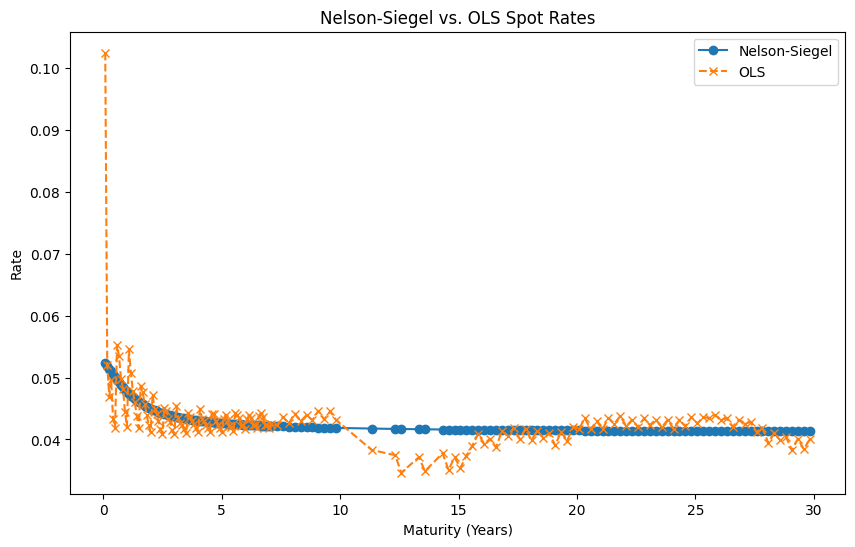

,OLS spot discount factor,time_to_maturity,semiannul_rate
2024-11-30,0.991618,0.082136,0.102480
2024-12-31,0.991355,0.167009,0.051992
2025-01-31,0.988255,0.251882,0.046906
2025-02-28,0.983813,0.328542,0.049673
2025-03-31,0.982278,0.413415,0.043252
...,...,...,...
2053-08-31,0.312216,28.832307,0.040373
2053-11-30,0.328910,29.081451,0.038236
2054-02-28,0.308188,29.327858,0.040134
2054-05-31,0.320794,29.579740,0.038437


In [39]:
def nelson_siegel(params,maturity):
    rate = params[0] + (params[1] + params[2]) * (1 - np.exp(-maturity/params[3]))/(maturity/params[3]) - params[2] * np.exp(-maturity/params[3])
    
    return rate

def discount_to_intrate(discount, maturity, n_compound=None):
    if n_compound is None:
        intrate = - np.log(discount) / maturity
    else:
        intrate = n_compound * (1 / discount**(1 / (n_compound * maturity)) - 1)
    return intrate

maturities = (nelson_seigel_cashflow_data.columns - pd.Timestamp("2024-10-31")).days / 365.25
rates_nelson_seigel = nelson_siegel(nelson_seigel_parameters, maturities)
# Convert to semiannual compounded rates
semiannual_rate_ns = (1 + rates_nelson_seigel /   2)**2 - 1
display(semiannual_rate_ns)

# OLS rates
ols_results["semiannul_rate"] = ols_results.apply( lambda row: discount_to_intrate(row["OLS spot discount factor"], row["time_to_maturity"]), axis=1)
display(ols_results["semiannul_rate"] )
plt.figure(figsize=(10, 6))
plt.plot(maturities, semiannual_rate_ns, label="Nelson-Siegel", marker='o', linestyle='-')
plt.plot(ols_results["time_to_maturity"], ols_results["semiannul_rate"] , label="OLS", marker='x', linestyle='--')
plt.xlabel("Maturity (Years)")
plt.ylabel("Rate")
plt.title("Nelson-Siegel vs. OLS Spot Rates")
plt.legend()
plt.show()

display(ols_results)

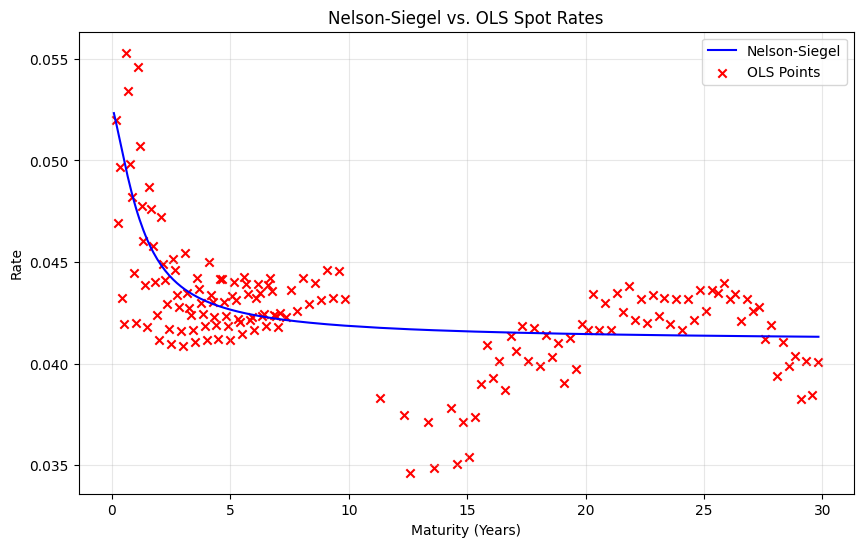

In [44]:
# Corecting the OLS rates

plt.figure(figsize=(10, 6))

# Nelson-Siegel curve
plt.plot(maturities, semiannual_rate_ns, label="Nelson-Siegel", linestyle='-', color='blue')

# OLS scatter points
ols_x = ols_results.loc["2024-12-31":, "time_to_maturity"]
ols_y = ols_results.loc["2024-12-31":, "semiannul_rate"]
plt.scatter(ols_x, ols_y, label="OLS Points", color='red', marker='x')


plt.xlabel("Maturity (Years)")
plt.ylabel("Rate")
plt.title("Nelson-Siegel vs. OLS Spot Rates")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

***

# 3. Yield-Curve Factors

### Data
This section uses data in `'../data/yields.xlsx`.



### 3.1. Yield Curve Movements

Use the yield curve time-series data to calculate the time-series of the **level**, **slope**, and **curvature** factors.

Calculate the yield-curve factors. For each point in time, calculate the following three factors:

$\begin{align}
x^{\text{level}}_t =& \frac{1}{N_{\text{yields}}}\sum_{i=1}^{N_{\text{yields}}} y^{(i)}_t\\
x^{\text{slope}}_t =& y^{(30)}_t - y^{(1)}_t\\
x^{\text{curvature}}_t =& -y^{(1)}_t + 2 y^{(10)}_t - y^{(30)}_t
\end{align}$

Report the 
* correlation matrix of the factors.
* *mean and volatility of the factors.

In [47]:
yield_data = pd.read_excel("data/yields.xlsx",
                           parse_dates=True)
yield_data.set_index("caldt", inplace=True)
yield_data

,1,2,5,7,10,20,30
caldt,,,,,,,
1961-06-14,2.935907,3.360687,3.623677,3.768720,3.818819,3.814210,3.815172
1961-06-15,2.932936,3.376460,3.671691,3.804225,3.862987,3.828220,3.826316
1961-06-16,2.929949,3.375670,3.685431,3.804216,3.863282,3.832922,3.830049
1961-06-19,2.920884,3.389970,3.712984,3.824557,3.886205,3.842378,3.837543
1961-06-20,2.952419,3.355796,3.685391,3.809274,3.886506,3.856465,3.845018
...,...,...,...,...,...,...,...
2024-05-24,5.151637,4.876767,4.477900,4.422071,4.413264,4.641009,4.513753
2024-05-28,5.149635,4.921106,4.550730,4.512302,4.498891,4.737532,4.612964
2024-05-29,5.231355,4.933358,4.603891,4.566732,4.561608,4.802605,4.679462


<Axes: >

,mean,vol
level,5.475250,2.914725
slope,1.109788,1.480255
curvature,4.366738,3.922933


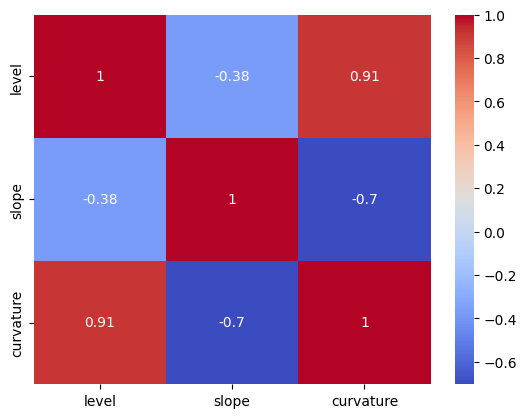

In [53]:
# Level factor
level_factor = yield_data.apply(lambda row: row.mean(), axis=1)
# Slope factor
slope_factor = yield_data[30] - yield_data[1]
# Curvature factor
curvature_factor = yield_data[1] + 2 * (yield_data[10] -
                                          yield_data[30])

factor_data = pd.DataFrame(data = {"level": level_factor,
                                    "slope": slope_factor,
                                    "curvature": curvature_factor})

# Correlation
correlation = factor_data.corr()
display(sns.heatmap(correlation, annot=True, cmap="coolwarm"))

# Mean and vol
mean = factor_data.mean()
vol = factor_data.std()
stats = pd.DataFrame(data = {"mean": mean, "vol": vol})
display(stats)

### 3.2. PCA

Calculate the principal components of the time-series yield data.

Report...
* the percentage of total variation explained by each factor.
* the loadings of the first two PCA factors.

#### Note
Consider using,
`PCA` from `sklearn.decomposition` 

In [54]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_results = pca.fit(yield_data)

# Variance explained by each component
explained_variance_ratio = pca_results.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

# Principal components (eigenvectors)
principal_components = pd.DataFrame(
    pca_results.components_,
    columns=yield_data.columns,
    index=[f"PC{i+1}" for i in range(pca.n_components)]
)
print("Principal Components (Eigenvectors):")
display(principal_components)

Explained Variance Ratio: [0.97070002 0.02527826 0.00294702]
Principal Components (Eigenvectors):


,1,2,5,7,10,20,30
PC1,0.411464,0.411054,0.392784,0.378353,0.363380,0.344069,0.337450
PC2,0.591006,0.399298,0.046806,-0.087439,-0.202674,-0.438856,-0.497760
PC3,0.455496,0.007324,-0.392437,-0.448402,-0.363501,0.363015,0.416516


### 3.3. Comparison

Compare the ad-hoc factors from `3.1.` with the PCA-estimated factors in `3.2.`.

Estimate the correlation of the ad-hoc level factor with the PCA-1. And the slope factor with PCA-2.

array([[-4.94438779,  0.6779322 , -0.31119508],
       [-4.88220337,  0.66097001, -0.35352345],
       [-4.87537906,  0.65555137, -0.35712371],
       ...,
       [-1.76485142,  1.6241075 ,  0.45217713],
       [-1.92224987,  1.63944693,  0.46377784],
       [-2.05325384,  1.62952661,  0.48264679]])

(15723, 3)
(15723, 3)


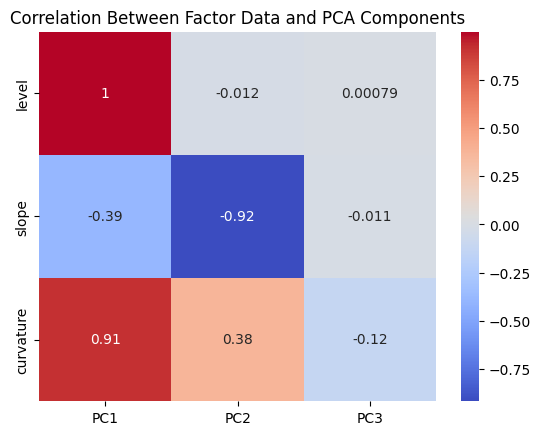

In [62]:
PCA_factors = pca_results.transform(yield_data)
display(PCA_factors)
print(PCA_factors.shape)
print(factor_data.shape)
PCA_dataframe = pd.DataFrame(data = PCA_factors,
                                index = yield_data.index,
                                columns = [f"PC{i+1}" for i in range(pca.n_components)])

# Initialize a DataFrame to store correlations
correlation_results = pd.DataFrame(index=factor_data.columns, columns=[f"PC{i+1}" for i in range(PCA_dataframe.shape[1])])

# Compute correlations for each PCA column with corresponding factor data
for i in range(PCA_dataframe.shape[1]):
    correlation_results.iloc[:, i] = factor_data.corrwith(PCA_dataframe.iloc[:, i])

# Plot the heatmap
sns.heatmap(correlation_results.astype(float), annot=True, cmap="coolwarm")
plt.title("Correlation Between Factor Data and PCA Components")
plt.show()
